### Compare hyper-parameter optimization performance for a simple SVR
**(over C and gamma) using HyperOpt and a random search**

In [1]:
%matplotlib inline
from time import time
import numpy as np
import pandas as pd
from sklearn import model_selection
from sklearn import svm
import matplotlib.pyplot as plt
from hyperopt import fmin, tpe, hp, space_eval
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
plt.style.use(['dark_background'])

In [2]:
def objective_hyperopt(params, k_folds=10):
    kf = model_selection.KFold(n_splits=k_folds)
    objective_val = 0
    for train_index, test_index in kf.split(X):
        x_train, x_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        model = svm.SVR(kernel='rbf', C=params['C'], gamma=params['gamma'])
        model.fit(x_train, y_train)
        accuracy = model.score(x_test, y_test)
        objective_val += 1 - accuracy  # objective = the error
    return objective_val

def param_space_hyperopt(c1, c2, g1, g2):
    params = {
        'C': hp.uniform("C", c1, c2),
        'gamma': hp.uniform("gamma", g1, g2),
    }
    return params

## Generate data:

In [4]:
np.random.seed(1)
n_data_points = 50
X = np.sort(5 * np.random.rand(n_data_points, 1), axis=0)
# Noise-free data:
y0 = np.sin(X).ravel()  
# Noisy data:
noise_scale = 0.5
y = y0 + np.random.uniform(-noise_scale, noise_scale, n_data_points)

In [5]:
# Range of parameter values:
C_min, C_max = 100, 100000
gamma_min, gamma_max = 0, 0.5

# --- Default model:
model_default = svm.SVR(kernel='rbf', C=1e3, gamma=0.1)
model_default.fit(X, y)
y_default = model_default.predict(X)

In [6]:
## Grid Search

In [24]:
p1_steps, p2_steps = 10, 10  # for the posted plots I used 50, 50
model_grid = svm.SVR(kernel='rbf')
gr1 = np.linspace(C_min, C_max, p1_steps).round(2).tolist()
gr2 = np.linspace(gamma_min, gamma_max, p2_steps).round(3).tolist()
param_grid = {'C': gr1, 'gamma': gr2}
gridsearch = GridSearchCV(model_grid, param_grid, return_train_score=True)
start = time()
gridsearch.fit(X, y)
stop = time()
print("Grid Search took %.2f seconds." % (stop - start))
gs_best_results_dict = gridsearch.best_params_
best_score = gridsearch.best_score_
print(gs_best_results_dict)
print('best score = ', best_score, '; objective val = ', 1 - best_score)

Grid Search took 11.41 seconds.
{'C': 100.0, 'gamma': 0.056}
best score =  0.052026464658163366 ; objective val =  0.9479735353418366


[Text(69.0, 0.5, 'C'), Text(0.5, 51.0, 'gamma')]

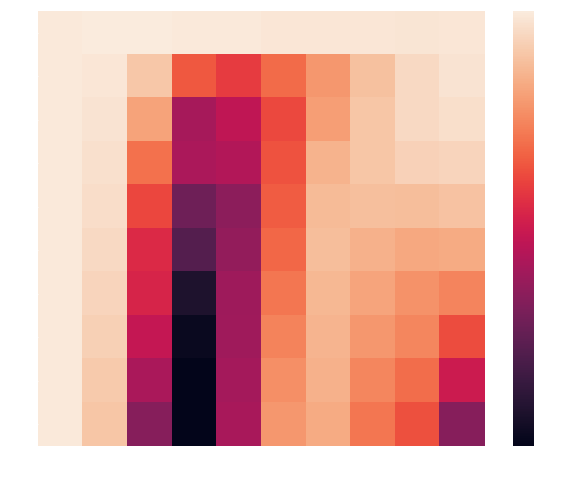

In [25]:
# Use best parameter values:
final_model_grid = svm.SVR(kernel='rbf', C=gs_best_results_dict['C'], gamma=gs_best_results_dict['gamma'])
final_model_grid.fit(X, y)
y_grid = final_model_grid.predict(X)
pvt_gs = pd.pivot_table(pd.DataFrame(gridsearch.cv_results_), values='mean_test_score', index='param_C', columns='param_gamma')
fig_gs = plt.figure(figsize=(10, 8))
ax = sns.heatmap(pvt_gs)
ax.set(xlabel='gamma', ylabel='C')

In [10]:
scorer = make_scorer(mean_squared_error, greater_is_better=False)

In [11]:
# --- Hyperopt:
iterations = 30
parameters = param_space_hyperopt(C_min, C_max, gamma_min, gamma_max)
start = time()
best = fmin(fn=objective_hyperopt, space=parameters, algo=tpe.suggest, max_evals=iterations)
hyperopt_results_dict = space_eval(parameters, best)
stop = time()
model_hyp = svm.SVR(kernel='rbf', C=hyperopt_results_dict['C'], gamma=hyperopt_results_dict['gamma'])
model_hyp.fit(X, y)
y_hyp = model_hyp.predict(X)

In [12]:
# --- Summary:
print('HyperOpt best = ', hyperopt_results_dict)
print('score (Default) = %2.3f, MSE = %.4f' % (model_default.score(X, y), mean_squared_error(y0, y_default)))
print('score (Grid Search) = %2.3f, MSE = %.4f' % (final_model_grid.score(X, y), mean_squared_error(y0, y_grid)))
print('score (HyperOpt) = %2.3f, MSE = %.4f' % (model_hyp.score(X, y), mean_squared_error(y0, y_hyp)))

HyperOpt best =  {'C': 42992.19445722054, 'gamma': 0.004939778713359192}
score (Default) = 0.880, MSE = 0.0147
score (Grid Search) = 0.881, MSE = 0.0112
score (HyperOpt) = 0.874, MSE = 0.0190


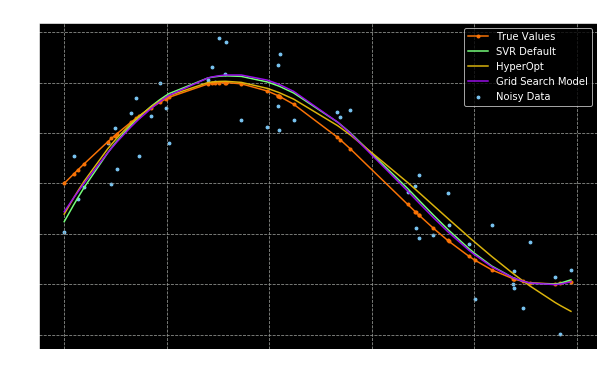

In [15]:
mkr_size = 3
fig = plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='xkcd:lightblue', marker='o', s=8, label='Noisy Data')
plt.plot(X, y0, color='xkcd:orange', linestyle='-', marker='o', markersize=mkr_size, label='True Values')
plt.plot(X, y_default, color='xkcd:lightgreen', markersize=mkr_size, label='SVR Default')
plt.plot(X, y_hyp, color='xkcd:gold', linestyle='-', label='HyperOpt')
plt.plot(X, y_grid, color='xkcd:violet', linestyle='-', label='Grid Search Model')
plt.legend()
plt.grid()
plt.title('Comparison between HyperOpt and Randomized Search')
plt.tick_params(axis='both', grid_alpha=1, grid_color='xkcd:grey', grid_linestyle='--', grid_linewidth=0.8)